In [151]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from scipy.optimize import minimize
from copy import deepcopy
import chainer
import chainer.links as L
import chainer.functions as F

In [152]:
num_h = 1

In [159]:
d = {}

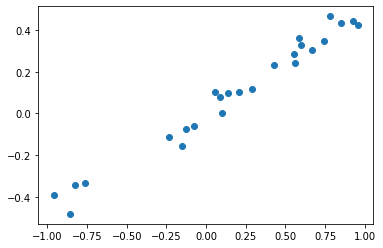

In [153]:
########  パラメータ  #############
## [x_min, x_max]のうち, ランダムにnum_x_train個の点をとって教師データとする.
x_min = - 1.; x_max = 1.;
num_x_train = 25
num_x_test = 25

## 学習したい1変数関数
func_to_learn = lambda x: 0.5*np.sin(x*np.pi)
func_to_learn1 = lambda x:np.abs(x) - 0.5
func_to_learn2 = lambda x:x*0.5

## 乱数のシード
random_seed = 0
## 乱数発生器の初期化
np.random.seed(random_seed)
### 教師データを準備
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn2(x_train)

# 現実のデータを用いる場合を想定し、きれいなsin関数にノイズを付加
mag_noise1 = 0.05
y_train = y_train + mag_noise1 * np.random.randn(num_x_train)

#テストデータの準備
mag_noise2 = 0
x_test = x_min + (x_max - x_min) * np.random.rand(num_x_test)
y_test = func_to_learn2(x_test) + mag_noise2 * np.random.randn(num_x_test)

plt.plot(x_train, y_train, "o"); plt.show()

In [154]:
x_train = x_train.astype(np.float32).reshape((len(x_train),1))
y_train = y_train.astype(np.float32).reshape((len(y_train),1))
x_test = x_test.astype(np.float32).reshape((len(x_test),1))
y_test = y_test.astype(np.float32).reshape((len(y_test),1))

In [122]:
class Net1(chainer.Chain):

    def __init__(self, n_in=1, n_hidden=3, n_out=1):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_in, n_hidden)
            self.l2 = L.Linear(n_hidden, n_out)

    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = self.l2(h)
        return h

In [123]:
class Net2(chainer.Chain):

    def __init__(self,n_in=1,n_hidden=3,n_out=1):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_in,n_hidden)
            self.l2 = L.Linear(n_hidden,n_hidden)
            self.l3 = L.Linear(n_hidden,n_out)

    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        return h

In [155]:
net = Net1(n_hidden=num_h)
optimizer = chainer.optimizers.SGD()
optimizer.setup(net)

In [156]:
n_epoch = 500
for epoch in range(n_epoch):
    # データセット並べ替えた順番を取得
    order = np.random.permutation(range(len(x_train)))
    for i in range(len(order)):
        # バッチを準備
        index = order[i]
        x_train_batch = x_train[index].reshape(1,1)
        y_train_batch = y_train[index:index+1]

        # 予測値を出力
        y_pred = net(x_train_batch)
        # 目的関数を適用
        loss_train_batch = F.squared_error(y_train_batch, y_pred)*0.5

        # 勾配のリセットと勾配の計算
        net.cleargrads()
        loss_train_batch.backward()

        # パラメータの更新
        optimizer.update()

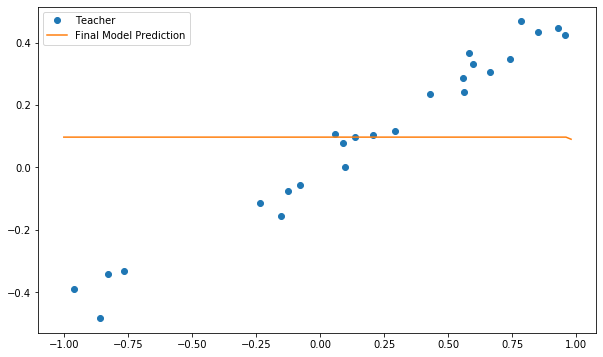

In [157]:
#プロットしたいときには以下を実行すればよい
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02).astype(np.float32)

# 教師データ
plt.plot(x_train, y_train, "o", label='Teacher')

# モデルの予測値
y_pred = np.array([net(x.reshape((1,1))).array[0][0] for x in xlist])

plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()

In [74]:
#ここまでがN.N.の学習フェーズ
#ここからNICの計算フェーズ

In [158]:
par = np.array([0]*(3*num_h+1),dtype=np.float32) #ここで学習済パラメータを1次元化する
for i in range(num_h):
    par[i] = net.l1.W.array[i][0]
for i in range(num_h,2*num_h):
    par[i] = net.l1.b.array[i%num_h]
for i in range(2*num_h,3*num_h):
    par[i] = net.l2.W.array[0][i%num_h]
par[3*num_h] = net.l2.b.array[0]

In [162]:
d[num_h] = d.get(num_h,[]) + [(D_ast(par,loss_func),gene_error(par,loss_func),NIC(par,loss_func))]
d[num_h]

In [138]:
class Net_after_optimization(chainer.Chain):
    def __init__(self,W_l1,b_l1,W_l2,b_l2,n_in=1,n_hidden=3,n_out=1):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_in, n_hidden,initialW=W_l1,initial_bias=b_l1)
            self.l2 = L.Linear(n_hidden, n_out,initialW=W_l2,initial_bias=b_l2)

    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = self.l2(h)
        return h

In [161]:
def loss_func(x,y,theta):
    #x:入力値、y:出力値、theta:学習後のパラメータベクトル,x,yは1次元のndarray(shape=(1,)となっている)
    #まず学習済パラメータを用いてモデルを構成し、その後損失関数を計算する
    #もし使うNNの形を変えるならこの構成部分をのコードを変える必要がある
    W1 = np.array([[0] for _ in range(num_h)],dtype = np.float32)
    b1 = np.array([0 for _ in range(num_h)],dtype = np.float32)
    W2 = np.array([[0 for _ in range(num_h)]],dtype = np.float32)
    b2 = np.array([0],dtype = np.float32)
    for i in range(num_h):
        W1[i][0] = theta[i]
    for i in range(num_h,2*num_h):
        b1[i%num_h] = theta[i]
    for i in range(2*num_h,3*num_h):
        W2[0][i%num_h] = theta[i]
    b2[0] = theta[3*num_h]
    new_net = Net_after_optimization(n_hidden=num_h,W_l1=W1,b_l1=b1,W_l2=W2,b_l2=b2)
    
    
    y_pred = new_net(x.reshape(1,1)).array[0][0]
    return 0.5*((y[0]-y_pred)**2)

In [111]:
def compute_gradient1(loss,x,y,theta,num):
    #loss: 使うloss関数、x,y:i番目のデータ,theta:今のパラメータベクトル,num: 何番目のパラメータについて偏微分をとるか
    #出力は勾配ベクトル
    h = 1e-4
    theta1,theta2 = theta.copy(),theta.copy()
    theta1[num] += h
    theta2[num] -= h
    return (loss(x,y,theta1)-loss(x,y,theta2))/(2*h)

In [112]:
def compute_gradient2(loss,x,y,theta,num1,num2):
    h = 1e-4
    if num1 == num2:
        theta1,theta2 = theta.copy(),theta.copy()
        theta1[num1] += h
        theta2[num1] -= h
        return (loss(x,y,theta1) + loss(x,y,theta2) -2*loss(x,y,theta))/(h**2)
    else:
        theta1,theta2,theta3,theta4 = theta.copy(),theta.copy(),theta.copy(),theta.copy()
        theta1[num1],theta1[num2] = theta[num1]+h,theta[num2]+h
        theta2[num1],theta2[num2] = theta[num1]+h,theta[num2]-h
        theta3[num1],theta3[num2] = theta[num1]-h,theta[num2]+h
        theta4[num1],theta4[num2] = theta[num1]-h,theta[num2]-h
        return (loss(x,y,theta1) + loss(x,y,theta4) - loss(x,y,theta2) - loss(x,y,theta3))/(4*(h**2))

In [113]:
def G_ast(par,loss):
    #入力:学習後のパラメータ、出力:行列G^ast
    n = len(par)
    G = np.array([[0 for _ in range(n)] for _ in range(n)])
    E_x = [0]*n    #E_x[i] = i番目の偏微分の期待値
    E_xy = [[0 for _ in range(n)] for _ in range(n)]  #E_xy[i][j] = i,j番目の偏微分の期待値
    for i in range(n):
        element = 0
        for x,y in zip(x_train,y_train):
            element += compute_gradient1(loss,x,y,par,i)
        element /= float(len(x_train))
        E_x[i] = element
        
    for i in range(n):
        for j in range(n):
            if i <= j:
                element = 0
                for x,y in zip(x_train,y_train):
                    element += compute_gradient1(loss,x,y,par,i)*compute_gradient1(loss,x,y,par,j)
                element /= float(len(x_train))
                E_xy[i][j] = element
            else:
                E_xy[i][j] = E_xy[j][i]
    
    for i in range(n):
        for j in range(n):
            G[i][j] = E_xy[i][j] - E_x[i]*E_x[j]
    return G

In [114]:
def Q_ast(par,loss):
    #入力:学習後のパラメータ、出力:行列Q^ast
    n = len(par)
    Q = np.array([[0 for _ in range(n)] for _ in range(n)])
    for i in range(n):
        for j in range(n):
            element = 0
            for x,y in zip(x_train,y_train):
                element += compute_gradient2(loss,x,y,par,i,j)
            element /= float(len(x_train))
            Q[i][j] = element
    return Q

In [115]:
def D_ast(par,loss):
    res = 0
    for x,y in zip(x_train,y_train):
        res += loss(x,y,par)
    res /= float(len(x_train))
    return res

In [116]:
def NIC(par,loss):
    f1 = D_ast(par,loss)
    G = G_ast(par,loss)
    Q = Q_ast(par,loss)
    Q_inv = np.linalg.pinv(Q)
    temp = np.dot(G,Q_inv)
    return f1 + np.trace(temp)/float(len(x_train))

In [118]:
def gene_error(par,loss):
    res = 0
    for x,y in zip(x_test,y_test):
        res += loss(x,y,par)
    res /= float(len(x_train))
    return res